<a id="top"></a>
## Table of Contents

[1. Functions](#functions)<br>
[2. Read and Clean](#read_clean)<br>
[3. Dataframe set up](#df_setup)<br>
[4. Hypothesis testing](#hypothesis)<br>


In [1]:
import numpy as np
import math
from math import sin, cos, sqrt, atan2, radians
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from scipy.stats import boxcox
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
pd.options.display.max_rows = 50

from scipy import stats

<a id="functions"></a>
## 1. Functions

In [2]:
def split_column_names_by(this_df, include_dtypes:[list]=["int","float"]):
    # __author__ = "Roman Kaltschew"
    """takes in this_df, splits this_df's columns into two lists of column name by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_lst, excl_lst)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (incl_lst, excl_lst)

In [3]:
def plot_hist_normalized(this_column, this_scaler: [str] = "standard_scaler"):
    # __author__ = "Roman Kaltschew"
    if this_scaler == "power_transformator":
        pt = PowerTransformer()
        col_transformed_pt=pt.fit_transform(this_column.to_numpy().reshape(-1,1))
        sns.displot(col_transformed_pt).set(title=f"{this_column.name} - PowerTransformer") 
    elif this_scaler == "quantile_transformer":
        qt = QuantileTransformer(n_quantiles=500, output_distribution="normal")
        col_transformed_qt=qt.fit_transform(this_column.to_numpy().reshape(-1,1))
        sns.displot(col_transformed_qt).set(title=f"{this_column.name} - QuantileTransformer")
    else:
        sc = StandardScaler()
        col_transformed_sc=sc.fit_transform(this_column.to_numpy().reshape(-1,1))
        sns.displot(col_transformed_sc).set(title=f"{this_column.name} - StandardScaler")

In [4]:
def boxplots_for_all_numerical_cols(this_df):
    # __author__ = "Roman Kaltschew"
    fig, ax = plt.subplots(figsize=(10,10))
    len_num_lst = len(split_column_names_by(this_df)[0])
    i = 1
    for col in split_column_names_by(this_df)[0]:            
        plt.subplot(math.ceil(len_num_lst**.5),math.ceil(len_num_lst**.5),i)
        sns.boxplot(y=this_df[col]).set(title=f"{col}")
        i += 1

In [5]:
def split_df_by(this_df, include_dtypes:[list]=["int","float"]):
    # __author__ = "Roman Kaltschew"
    """takes in this_df, splits it into two NEW DF's by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_df, excl_df)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (this_df[incl_lst], this_df[excl_lst])

In [6]:
def all_numeric_to_int(this_df):
    # __author__ = "Roman Kaltschew"
    for col in this_df._get_numeric_data():
        this_df[col] = this_df[col].astype(np.int64)
    return this_df

In [7]:
def all_strings_lowercase(this_df):
    # __author__ = "Roman Kaltschew"
    for col in this_df:
        this_df[col] = this_df[col].map(lambda x: x.lower() if isinstance(x,str) else x)
    return this_df

In [8]:
def nan_values_of_all_columns(this_df, return_dict:[bool] = False):
    # __author__ = "Roman Kaltschew"
    """prints (defaults) or returns dictionary of all columns in this_df and their respective nan-values"""
    if not return_dict:
        for col in this_df.columns:
            print(col, this_df[col].isna().sum())
        return
    return {col:this_df[col].isna().sum() for col in this_df.columns}

In [9]:
def extract_year_month(this_date:[str]=None):
    # __author__ = "Roman Kaltschew"
    """takes this_date in format MM/DD/YYYY and returns YYYY_MM"""
    if this_date:
        return this_date.split("/")[2]+"_"+this_date.split("/")[0]
    return None

In [10]:
def extract_month(this_date:[str]=None, as_type:[str]=None):
    # __author__ = "Roman Kaltschew"
    """takes this_date in format MM/DD/YYYY and returns MM as_type (default str)"""
    if this_date:
        if as_type == "int":
            return int(this_date.split("/")[0])
        else:
            return str(this_date.split("/")[0])
    return None

In [11]:
def corr_mat(num_df):
    corr = num_df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(9, 7))
        ax = sns.heatmap(corr, mask=mask,cmap='coolwarm', vmin=-1,vmax=1,annot=True, square=True)

In [12]:
def return_year(this_date:[str]=None):
    # __author__ = "Roman Kaltschew"
    return int(this_date.split("/")[2])

In [13]:
def return_distance(coord:[tuple]):
    # __author__ = "Roman Kaltschew"
    """takes in a tuple of lat and lon, calculates distance to coords_center_top_prices calculated BEFORE running this function"""
    R = 3958.8   # radius of earth in miles

    lat1 = radians(coords_center_top_prices[0])
    lon1 = radians(coords_center_top_prices[1])

    lat2 = radians(coord[0])
    lon2 = radians(coord[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

[top of notebook](#top)

<a id='read_clean'></a>

## 2 Read and Clean

In [257]:
data = pd.read_csv("data/regression_data.csv")
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/2014,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/2014,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2/25/2015,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,12/9/2014,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2/18/2015,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


<a id="classifying_columns"></a>
### 2.1 Classifying columns

+ divide columns in numerical and discrete

In [258]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  int64  
 8   view           21597 non-null  int64  
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  int64  
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [259]:
for col in data.columns:
    data[col] = data[col].astype('category')

In [260]:
for col in ["sqft_living", "sqft_lot", "sqft_above", "sqft_basement", "price", "sqft_living15", "sqft_lot15", "yr_built", "yr_renovated"]:
    data[col] = data[col].astype("int64")

[top of notebook](#top)

<a id="numericals"></a>
### 2.2 Numericals

#### 2.2.1 Check for NaNs

In [261]:
nan_values_of_all_columns(data[split_column_names_by(data)[0]])

sqft_living 0
sqft_lot 0
sqft_above 0
sqft_basement 0
yr_built 0
yr_renovated 0
sqft_living15 0
sqft_lot15 0
price 0


#### 2.2.2 Boxplots - check for outliers

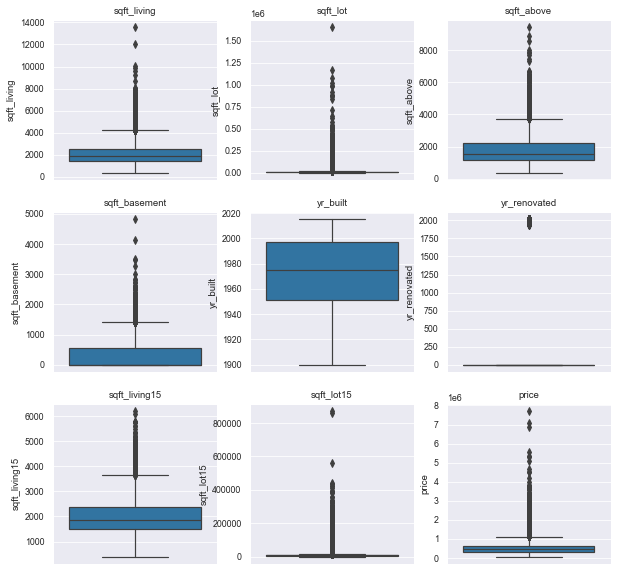

In [262]:
boxplots_for_all_numerical_cols(data)

##### bedroom outlier

In [263]:
data[data["bedrooms"] == max(data["bedrooms"])][["bedrooms","sqft_living"]]

,bedrooms,sqft_living
15856,33,1620


In [264]:
print(f"Average living space of tree bedrooms: {round(np.mean(data[data['bedrooms']==3]['sqft_living']), 2)}")
print(f"Average living space of two bedrooms: {round(np.mean(data[data['bedrooms']==2]['sqft_living']), 2)}")

Average living space of tree bedrooms: 1805.84
Average living space of two bedrooms: 1239.75


+ it is likely, that the 33 is a typo, it will be changed to 3

In [265]:
data.at[15856,"bedrooms"] = 3

##### sqft_lot outlier

In [266]:
print(data[data["sqft_lot"] == max(data["sqft_lot"])][["bedrooms","sqft_lot"]])

     bedrooms  sqft_lot
1717        4   1651359


In [267]:
print(f"Average lot in ft² of four bedrooms: {round(np.mean(data[data['bedrooms']==4]['sqft_lot']), 2)}")


Average lot in ft² of four bedrooms: 16720.79


+ it is likely, that a comma was forgotton, sqft_lot will be set to 16513.59

In [268]:
data.at[1717,"sqft_lot"] = 16513.59

##### sqft_living

In [269]:
# max sqft_living
data[data["sqft_living"] == max(data["sqft_living"])]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
12764,1225069038,5/5/2014,7,8.0,13540,307752,3.0,0,4,3,...,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800,2280000


In [270]:
# sqft_living > 10000
data[data["sqft_living"] > 10000]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
3910,9808700762,6/11/2014,5,4.5,10040,37325,2.0,1,2,3,...,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449,7060000
7245,6762700020,10/13/2014,6,8.0,12050,27600,2.5,0,3,4,...,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,7700000
12764,1225069038,5/5/2014,7,8.0,13540,307752,3.0,0,4,3,...,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800,2280000


consider dropping these for modelling, as they don't represent a "normal" property in this dataset<br>
update: in the model with the highest adjusted r², these properties are excluded by price filtering

##### sqft_basement

In [271]:
# max sqft_basement
data[data["sqft_basement"] == max(data["sqft_basement"])]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
8085,1924059029,6/17/2014,5,6.75,9640,13068,1.0,1,4,3,...,4820,4820,1983,2009,98040,47.557,-122.21,3270,10454,4670000


In [272]:
print(f"Average sqft_basement of five bedrooms: {round(np.mean(data[data['bedrooms']==5]['sqft_basement']), 2)}")
print(f"Average sqft_above of five bedrooms: {round(np.mean(data[data['bedrooms']==5]['sqft_above']), 2)}")

Average sqft_basement of five bedrooms: 639.98
Average sqft_above of five bedrooms: 2407.57


no suitable solution found apart from dropping datapoint completely

#### 2.2.3 Build age at time of sale column (feature engineering)

In [273]:
data["year_sold"] = list(map(return_year, data["date"]))

In [274]:
data["year_last"] = data["yr_built"]

In [275]:
# get indeces of renovated properties
ren_lst = list(data[data["yr_renovated"] != 0].index)

In [276]:
# change respectective rows
for i in ren_lst:
    data.at[i,"year_last"] = data["yr_renovated"].iloc[i]

In [277]:
data["age_in_2015"] = 2015 - data["year_last"]

#### 2.2.4 average sqft price according to view

In [278]:
data["sqft_price"] = data["price"] / data["sqft_living"]
for v in range(5):
    print("View =", v," → ", np.mean(data[data["view"] == v]["sqft_price"]))

View = 0  →  256.8777439007596
View = 1  →  319.97283025967334
View = 2  →  304.35271830456304
View = 3  →  322.6116490600102
View = 4  →  434.998060993705


#### 2.2.5 Change all numeric values to integer

+ decided **against**, as most of the data is already numerical and some data shouldn't be (long, lat, rooms, ...)

In [279]:
# data = all_numeric_to_int(ca_df)

<a id = "categoricals"></a>
### 2.3 Categorical columns

#### 2.2.1 Check for NaNs

In [280]:
nan_values_of_all_columns(data[split_column_names_by(data)[1]])

id 0
date 0
bedrooms 0
bathrooms 0
floors 0
waterfront 0
view 0
condition 0
grade 0
zipcode 0
lat 0
long 0


+ create month_sold column

In [281]:
data["month_sold"] = list(map(extract_month, data["date"]))

In [282]:
data["month_sold"] = data["month_sold"].astype('category')

#### 2.2.3 All strings to lower case

+ no need 

#### 2.2.4 Seattle Grading System

+ 1-3: minimum building standards, cabin or inferior structure.
+ 4: older, low quality construction.
+ 5: low construction costs, small and simple design.
+ 6: lowest grade currently meeting building code, low quality materials and simple designs.
+ 7: average grade of construction and design.
+ 8: just above average in construction and design, better materials.
+ 9: better architectural design and quality.
+ 10: high quality features, better design, generally larger square footage.
+ 11: custom design, higher quality and more luxurious features.
+ 12: custom design and excellent builders and materials.
+ 13: custom designed and built, mansion level.

In [283]:
# cf. TABLEAU SOLUTION 
grades = pd.DataFrame(data.groupby("grade").count()["id"])
grades["view"] = grades.index
# grades.plot(kind="bar")


In [284]:
grades["percent"] = round(grades["id"]/sum(grades["id"]) * 100, 2)
grades

,id,view,percent
grade,,,
3,1,3,0.00
4,27,4,0.13
5,242,5,1.12
6,2038,6,9.44
7,8974,7,41.55
8,6065,8,28.08
9,2615,9,12.11
10,1134,10,5.25
11,399,11,1.85


#### 2.2.5 Zipcode average mean price in 5 bins

In [285]:
# create new df zipcodes average sales price and bin these in 5 cats (1-5, evenly spread)
zipcodes_df = pd.DataFrame(data.groupby("zipcode").mean()["price"])
bin_labels = ['1', '2', '3', '4', '5']
zipcodes_df['area_pricing'] = pd.qcut(zipcodes_df['price'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=bin_labels)

In [286]:
# make a dictionary from the zipcode df
zipcodes_df.drop("price", axis=1, inplace=True)
zipcodes_df.to_dict()
zip_dict = zipcodes_df.to_dict()["area_pricing"]
for k,v in zip_dict.items():
    k = int(v)

In [287]:
# use this dictionary to create a new column according to average sales price
data['aver_price_zip_cat'] = data['zipcode'].map(zip_dict)
data["aver_price_zip_cat"] = data["aver_price_zip_cat"].astype("category")

#### 2.2.6 Lat Long Zoning

In [288]:
# Choose, how many top places should be included for "highest price center"
top_prices = 15

# create a df accordingly 
top_prices_df = data.sort_values("price", ascending=False)[["lat", "long", "price"]].head(top_prices)

# calculate coordinate tuple (lat, long)
coords_center_top_prices = ((round(np.mean(list(top_prices_df.lat)), 3)),
                              (round(np.mean(list(top_prices_df.long)), 3)))

In [289]:
# create new column with lat and long as tuple
data["coords"] = list(zip(list(data.lat), list(data.long)))

# create column with distance every data point to coords_center_top_prices
data["dist_to_top_center"] = list(map(return_distance, data.coords))

# create column with bins of calculated distance
bin_labels = ['1', '2', '3', '4', '5']
data['price_zone'] = pd.qcut(data['dist_to_top_center'],
                              q=[0, .2, .4, .6, .8, 1],
                              labels=bin_labels)
data["price_zone"] = data["price_zone"].astype("category")

In [290]:
print("center:", str(data[data["dist_to_top_center"] == min(data["dist_to_top_center"])]["coords"]))
print("max. dist:", data[data["dist_to_top_center"] == max(data["dist_to_top_center"])]["coords"])

center: 9245    (47.6305, -122.24)
Name: coords, dtype: object
max. dist: 2925    (47.713, -121.315)
Name: coords, dtype: object


##### 2.2.6.1 Price zone df

In [291]:
price_zone_dict = {}
for z in range (1, 6):
    price_zone_dict[z] = {}
    price_zone_dict[z]["aver_price"] = round(np.mean(data[data["price_zone"].astype("int64") == z]["price"]), 2)
    price_zone_dict[z]["aver_sqft_living"] = round(np.mean(data[data["price_zone"].astype("int64") == z]["sqft_living"]), 2)
    price_zone_dict[z]["aver_sqft_floors"] = round(np.mean(data[data["price_zone"].astype("int64") == z]["floors"].astype("float")), 1)
    price_zone_dict[z]["aver_sqft_lot"] = round(np.mean(data[data["price_zone"].astype("int64") == z]["sqft_lot"].astype("float")), 2)

In [292]:
zones_aver_df = pd.DataFrame.from_dict(price_zone_dict).transpose()
zones_aver_df

,aver_price,aver_sqft_living,aver_sqft_floors,aver_sqft_lot
1,801601.73,2201.83,1.5,7781.36
2,579105.72,1959.58,1.5,7454.99
3,513906.18,2049.19,1.4,11659.02
4,466016.30,2164.14,1.5,22235.21
5,340838.62,2026.85,1.5,25987.12


##### 2.2.6.2 Average price per ft² for 3 bedroom houses by zone

In [293]:
average_price_dict = {}
this_df = data[data["bedrooms"] == 3]

for z in range(1,6):
    average_price_dict[z] = {}
    average_price_dict[z]["av_pr_sqft"] = np.mean(this_df[this_df["price_zone"].astype("int64") == z]["sqft_price"])
    

In [294]:
average_price_dict[1]["percent_lower_that_zone1"] = 0

In [295]:
for z in range(2,6):
    average_price_dict[z]["percent_lower_that_zone1"] = round(1 - average_price_dict[z]["av_pr_sqft"] /average_price_dict[1]["av_pr_sqft"],4)*100


In [296]:
average_price_df = pd.DataFrame.from_dict(average_price_dict).transpose()
average_price_df

,av_pr_sqft,percent_lower_that_zone1
1,370.344604,0.00
2,303.170937,18.14
3,259.421377,29.95
4,218.552187,40.99
5,177.622635,52.04


In [297]:
# sns.barplot(data=average_price_df, x= average_price_df.index, y=average_price_df["percent_lower_that_zone1"], palette="rocket")


##### 2.2.6.3 map with concentric circles around center 

for use on https://www.freemaptools.com/concentric-circles.htm

"47.6305, -122.24", 0, 4, yellow<br>
"47.6305, -122.24", 4, 8, green<br>
"47.6305, -122.24", 8, 12, blue<br>
"47.6305, -122.24", 12, 16, brown<br>
"47.6305, -122.24", 16, 20, gray<br>




##### 2.2.6.4 quadrant df's

In [298]:
print("Overview: ")
print("northeast quadrant", len(data[data["lat"].astype("float64") > 47.6305][data[data["lat"].astype("float64") > 47.6305]["long"].astype("float64") > -122.24]))
print("northwest quadrant", len(data[data["lat"].astype("float64") > 47.6305][data[data["lat"].astype("float64") > 47.6305]["long"].astype("float64") < -122.24]))
print("southeast quadrant", len(data[data["lat"].astype("float64") < 47.6305][data[data["lat"].astype("float64") < 47.6305]["long"].astype("float64") > -122.24]))
print("southwest quadrant", len(data[data["lat"].astype("float64") < 47.6305][data[data["lat"].astype("float64") < 47.6305]["long"].astype("float64") < -122.24]))

Overview: 
northeast quadrant 3334
northwest quadrant 4809
southeast quadrant 7751
southwest quadrant 5673


In [299]:
# create 4 df according to quadrant using lat and long of each property
ne_df = data[data["lat"].astype("float64") > 47.6305][data[data["lat"].astype("float64") > 47.6305]["long"].astype("float64") > -122.24]
nw_df = data[data["lat"].astype("float64") > 47.6305][data[data["lat"].astype("float64") > 47.6305]["long"].astype("float64") < -122.24]
se_df = data[data["lat"].astype("float64") < 47.6305][data[data["lat"].astype("float64") < 47.6305]["long"].astype("float64") > -122.24]
sw_df = data[data["lat"].astype("float64") < 47.6305][data[data["lat"].astype("float64") < 47.6305]["long"].astype("float64") < -122.24]

In [300]:
# make a lst of these ↑ dataframes for the creation of the quad_dict
quad_lst = []
quad_lst.append(ne_df)
quad_lst.append(nw_df)
quad_lst.append(se_df)
quad_lst.append(sw_df)
quad_names = ["North East", "North West", "South East", "South West"]

In [301]:
quad_dict = {}
for q in range(4):
    quad_dict[quad_names[q]] = {}
    quad_dict[quad_names[q]]["Number of properties"] = len(quad_lst[q])
    quad_dict[quad_names[q]]["aver_price"] = round(np.mean(quad_lst[q]["price"].astype("float64")), 2)
    quad_dict[quad_names[q]]["aver_sqft"] = round(np.mean(quad_lst[q]["sqft_living"].astype("float64")), 2)
    quad_dict[quad_names[q]]["aver_floors"] = round(np.mean(quad_lst[q]["floors"].astype("float64")), 2)
    quad_dict[quad_names[q]]["aver_lot"] = round(np.mean(quad_lst[q]["sqft_lot"].astype("float64")), 2)
    

In [302]:
quad_data_df = pd.DataFrame.from_dict(quad_dict).transpose()
quad_data_df

,Number of properties,aver_price,aver_sqft,aver_floors,aver_lot
North East,3334.0,642678.50,2374.56,1.53,22805.19
North West,4809.0,605032.12,1857.14,1.50,6295.62
South East,7751.0,536684.17,2298.89,1.55,20892.15
South West,5673.0,427844.93,1795.84,1.40,9844.67


[top of notebook](#top)

## 3. Adjust the DataFrame to fine tune the model

Different adjustments were made (cf. headlines), optional re-run possible from each uncommented cell.<br>
For faster processing, a copy of the **data** df is made for each adjustment. 

<a id="df_setup"></a>
### 3.1 Dataframe set up
Create a copy of the cleaned DataFrame to avoid multiple new runs of the cleaning process

In [303]:
this_model = data.copy()
len(this_model)
filename_ext = "TO BE SET BEFORE RUNNING"

**In the following cells, adjust the DataFrame**

In [304]:
this_model.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price', 'year_sold', 'year_last',
       'age_in_2015', 'sqft_price', 'month_sold', 'aver_price_zip_cat',
       'coords', 'dist_to_top_center', 'price_zone'],
      dtype='object')

#### 3.1.1 trying different filtering approaches

##### 3.1.1.1 No further adjustments using price_zone

In [401]:
# this_model = data.copy()
# this_model.drop(["id", "date", "yr_renovated", "sqft_above", "year_sold", 
#                  "year_last", "yr_built", "long", "lat", "dist_to_top_center", "zipcode", 'aver_price_zip_cat', "sqft_price",
#                  "coords", "month_sold"], axis=1, inplace=True)

# filename_ext = "no_further_df_adjustments_price_zone"
# this_model = this_model.reset_index(drop=True)

[result](#result)

##### 3.1.1.2 dataframe using price_zone, excluding prices > 4_000_000

In [467]:
this_model = data.copy()
this_model.drop(["id", "date", "yr_renovated", "sqft_above", "year_sold", 
                 "year_last", "yr_built", "long", "lat", "dist_to_top_center", "zipcode", 'aver_price_zip_cat', "sqft_price",
                 "coords", "month_sold"], axis=1, inplace=True)
this_model = this_model[this_model["price"] < 4000000]
filename_ext = "df_w_price_zone_excl_4_mio_and_above"
this_model = this_model.reset_index(drop=True)

[result](#result)

[top of notebook](#top)

##### 3.1.1.3 df using pricezone and zipcode_zone, only properties for < 650K

In [468]:
# this_model = data.copy()
# this_model.drop(["id", "date", "yr_renovated", "sqft_above", "year_sold", 
#                  "year_last", "yr_built", "long", "lat", "dist_to_top_center", "zipcode", 'aver_price_zip_cat', "sqft_price",
#                  "coords", "month_sold"], axis=1, inplace=True)
# this_model = this_model[this_model["price"] < 650_000]
# this_model = this_model.reset_index(drop=True)
# filename_ext = "df_price_below_650k_price_zone"

##### 3.1.1.4 df using pricezone and zipcode_zone, only properties for > 650K

In [469]:
# this_model = data.copy()
# this_model.drop(["id", "date", "yr_renovated", "sqft_above", "year_sold", 
#                  "year_last", "yr_built", "long", "lat", "dist_to_top_center", "zipcode", 'aver_price_zip_cat', "sqft_price",
#                  "coords", "month_sold"], axis=1, inplace=True)
# this_model = this_model[this_model["price"] > 650_000]
# this_model = this_model.reset_index(drop=True)
# filename_ext = "df_price_above_650k_price_zone"

##### 3.1.1.5 create df view = 0 and waterfront = 0

In [470]:
# this_model = data.copy()
# this_model.drop(["id", "date", "yr_renovated", "sqft_above", "year_sold", 
#                  "year_last", "yr_built", "long", "lat", "dist_to_top_center", "zipcode", 'aver_price_zip_cat', "sqft_price",
#                  "coords", "month_sold"], axis=1, inplace=True)
# this_model = this_model[this_model["view"] == 0]
# this_model = this_model[this_model["waterfront"] == 0]
# filename_ext = "df_adjustments_price_zone_no_view_no_waterfront"
# this_model = this_model.reset_index(drop=True)


##### 3.1.1.6 create df view = 0 and waterfront = 0 and excluding 4 mio and above


In [471]:
# this_model = data.copy()
# this_model.drop(["id", "date", "yr_renovated", "sqft_above", "year_sold", 
#                  "year_last", "yr_built", "long", "lat", "dist_to_top_center", "zipcode", 'aver_price_zip_cat', "sqft_price",
#                  "coords", "month_sold"], axis=1, inplace=True)
# this_model = this_model[this_model["view"] == 0]
# this_model = this_model[this_model["waterfront"] == 0]
# this_model = this_model[this_model["price"] < 4_000_000]
# filename_ext = "df_adjustments_price_zone_no_view_no_waterfront_price_under_4mio"
# this_model = this_model.reset_index(drop=True)


##### 3.1.1.7 Remove all outliers


In [472]:
# this_model = data.copy()
# this_model.drop(["id", "date", "yr_renovated", "sqft_above", "year_sold", 
#                  "year_last", "yr_built", "long", "lat", "dist_to_top_center", "zipcode", 'aver_price_zip_cat', "sqft_price",
#                  "coords", "month_sold"], axis=1, inplace=True)
# this_model = this_model[(np.abs(stats.zscore(this_model.select_dtypes(include=np.number))) < 3).all(axis=1)]
# filename_ext = "df_adjustments_remove_outliers"
# this_model = this_model.reset_index(drop=True)


##### 3.1.1.8   tester

In [473]:
# this_model = data.copy()
# drop all but 6 main features including price
# this_model.drop(["id", "date", "yr_renovated", "sqft_above", "year_sold", "sqft_price",
#                  "year_last", "yr_built", "long", "lat", "dist_to_top_center", "zipcode", 'aver_price_zip_cat',
#                  'bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'age_in_2015', "sqft_lot15", "sqft_basement", "condition",
#                  "coords", "month_sold", "sqft_living15"], axis=1, inplace=True)

# this_model.drop(["id", "date", "yr_renovated", "sqft_above", "year_sold", 
#                 "sqft_living15", "sqft_lot15",
#                  "year_last", "yr_built", "long", "lat", "dist_to_top_center", "zipcode", 'aver_price_zip_cat', "sqft_price",
#                  "coords", "month_sold"], axis=1, inplace=True)
# this_model = this_model[this_model["price"] < 4000000]
# this_model = this_model[this_model["price"] < 4_000_000]
# filename_ext = "df_experimental"
# this_model = this_model.reset_index(drop=True)


In [474]:
# placeholder

<a id="scaler"></a>
##### 3.1.1.10 Select scaling method by (un)commenting contents of the following cell:

In [475]:
scaler = "standard_scaler"
# scaler = "quantile_transformer"
# scaler = "power_transformator"  # not completely tested


***Select the size of the test set***

In [476]:
test_set_size = .30

<a id="options"></a>
##### 3.1.1.11 Select further options:

In [477]:
show_boxplots_for_all_numerical = False
show_histograms_for_normalized_cols = False
show_hist_for_X = False
print_model_data = False
show_prediction_plots = True
show_beta_plot = True
save_beta_plot = False
save_pred_plot = False
save_error_metric = False

When complete, run code and find the result under [output](#result).

#### 3.1.1 Numerical

In [478]:
if show_boxplots_for_all_numerical:
    boxplots_for_all_numerical_cols(split_df_by(this_model)[0])

In [479]:
if show_histograms_for_normalized_cols:
    for col in split_column_names_by(this_model)[0]:
        plot_hist_normalized(this_model[col], scaler)

#### 3.1.2 Categorical

In [480]:
categoricals_features= this_model.select_dtypes("category")
categoricals_features.reset_index(drop=True)

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,price_zone
0,3,1.00,1.0,0,0,3,7,3
1,3,2.25,2.0,0,0,3,7,2
2,2,1.00,1.0,0,0,3,6,2
3,4,3.00,1.0,0,0,5,7,4
4,3,2.00,1.0,0,0,3,8,3
...,...,...,...,...,...,...,...,...
21580,3,2.50,3.0,0,0,3,8,2
21581,4,2.50,2.0,0,0,3,8,3
21582,2,0.75,2.0,0,0,3,7,1
21583,3,2.50,2.0,0,0,3,8,4


In [481]:
#cat_cols

In [482]:
cat_cols=pd.get_dummies(categoricals_features, drop_first=True)

#### 3.1.3 X-y split

In [483]:
X=this_model.drop("price", axis=1)
y=this_model["price"]

In [484]:
X_num = X._get_numeric_data()
X_num = X_num.reset_index(drop=True)
X_num

,sqft_living,sqft_lot,sqft_basement,sqft_living15,sqft_lot15,age_in_2015
0,1180,5650,0,1340,5650,60
1,2570,7242,400,1690,7639,24
2,770,10000,0,2720,8062,82
3,1960,5000,910,1360,5000,50
4,1680,8080,0,1800,7503,28
...,...,...,...,...,...,...
21580,1530,1131,0,1530,1509,6
21581,2310,5813,0,1830,7200,1
21582,1020,1350,0,1020,2007,6
21583,1600,2388,0,1410,1287,11


In [485]:
if show_hist_for_X:
    X_num.hist(figsize=(14,14))

In [486]:
# cat_cols

**Concat dummies to numeric standardized**

In [487]:
X = pd.concat([X_num,categoricals_features],axis=1)
X = X.reset_index(drop=True)
X

,sqft_living,sqft_lot,sqft_basement,sqft_living15,sqft_lot15,age_in_2015,bedrooms,bathrooms,floors,waterfront,view,condition,grade,price_zone
0,1180,5650,0,1340,5650,60,3,1.00,1.0,0,0,3,7,3
1,2570,7242,400,1690,7639,24,3,2.25,2.0,0,0,3,7,2
2,770,10000,0,2720,8062,82,2,1.00,1.0,0,0,3,6,2
3,1960,5000,910,1360,5000,50,4,3.00,1.0,0,0,5,7,4
4,1680,8080,0,1800,7503,28,3,2.00,1.0,0,0,3,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21580,1530,1131,0,1530,1509,6,3,2.50,3.0,0,0,3,8,2
21581,2310,5813,0,1830,7200,1,4,2.50,2.0,0,0,3,8,3
21582,1020,1350,0,1020,2007,6,2,0.75,2.0,0,0,3,7,1
21583,1600,2388,0,1410,1287,11,3,2.50,2.0,0,0,3,8,4


#### 3.1.4 Data splitting

In [488]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size,random_state=42)

In [489]:
y_train.values.reshape(-1,1)
# y_test.values.reshape(-1,1)
y_train = y_train.reset_index(drop=True)


In [490]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [491]:
X_train
X_test

,sqft_living,sqft_lot,sqft_basement,sqft_living15,sqft_lot15,age_in_2015,bedrooms,bathrooms,floors,waterfront,view,condition,grade,price_zone
0,1490,1294,270,1490,1283,5,3,2.25,2.0,0,0,3,7,2
1,1970,7213,800,1980,7045,38,4,2.75,1.0,0,0,3,8,4
2,1200,8631,0,1564,8115,56,3,1.75,1.0,0,0,3,7,5
3,980,5600,0,1840,5302,66,3,1.00,1.0,0,0,2,6,3
4,1580,1321,500,1530,1357,1,3,2.50,2.0,0,2,3,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6471,2760,3865,0,2590,4587,2,5,3.50,2.5,0,0,3,8,3
6472,1910,12596,570,1550,13310,38,3,1.75,1.0,0,0,3,7,3
6473,2380,6600,0,1870,6600,5,2,2.50,1.0,0,0,3,8,4
6474,2390,6820,250,1980,6820,70,4,2.75,2.0,0,0,4,7,1


#### 3.1.5 Standardize
+ Build scaling parameters on training set (mean variance) → more data as majority of datapoints of sample<br>(1 - *test_sample_size*) <br>



In [492]:
if scaler == "quantile_transformer":
    scaler_used = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(X_train)
elif scaler == "power_transformator":
    scaler_used = PowerTransformer().fit(X_train)
else:
    scaler_used = StandardScaler().fit(X_train)

+ Apply on training set

In [493]:
X_train_scaled=scaler_used.transform(X_train)

+ as well as on test set (same std_scaler but generated by a bigger set of values), same scaling param's as x_train

In [494]:
X_test_scaled=scaler_used.transform(X_test)

#### 3.1.6 Modeling using Statsmodels

In [495]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns= X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns= X_test.columns)

X_train_scaled = X_train_scaled.reset_index(drop=True)
X_test_scaled = X_test_scaled.reset_index(drop=True)


In [496]:
# y_train=y_train.values.reshape(-1,1)
# y_test=y_test.values.reshape(-1,1)


In [497]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant
# X_train_const_scaled = X_train_const_scaled.reset_index(drop=True)
model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
if print_model_data:
    print(print_model)

In [498]:
predictions_test

0       390516.055726
1       396110.083960
2       149090.160805
3       183019.129750
4       498965.373011
            ...      
6471    620036.031892
6472    401746.025209
6473    538287.519575
6474    742376.987960
6475    778293.767939
Length: 6476, dtype: float64

#### 3.1.7 Modeling using Scikit Learn

##### 3.1.7.1 Model fitting

In [499]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train

LinearRegression()

##### 3.1.7.2 Parameters of model

In [500]:
model.coef_

array([ 159756.03735147,   10216.49732131,  -29129.22360771,
         24033.49779358,   -1443.83275455,   29532.49529742,
        -27624.88334882,   23093.60407641,  -13271.89522273,
         44625.48999384,   44592.26479787,   19100.78648299,
         88924.04772413, -129613.19799402])

In [501]:
print(list(zip(model.coef_, X_train.columns)))

[(159756.03735147248, 'sqft_living'), (10216.497321307921, 'sqft_lot'), (-29129.223607712764, 'sqft_basement'), (24033.497793575047, 'sqft_living15'), (-1443.8327545489008, 'sqft_lot15'), (29532.49529741539, 'age_in_2015'), (-27624.883348824784, 'bedrooms'), (23093.6040764052, 'bathrooms'), (-13271.895222729923, 'floors'), (44625.489993842304, 'waterfront'), (44592.26479786798, 'view'), (19100.78648299164, 'condition'), (88924.04772412592, 'grade'), (-129613.1979940163, 'price_zone')]


In [502]:
coef_dict = {}
for coef, feat in list(zip(model.coef_, X.columns)):
    coef_dict[feat] = abs(coef)

In [503]:
# coef_dict_rev = {}
# for coef, feat in list(zip(model.coef_, X.columns)):
#     coef_dict_rev[str(abs(coef))] = feat

In [504]:
coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1], reverse=True)}
coef_dict

{'sqft_living': 159756.03735147248,
 'price_zone': 129613.1979940163,
 'grade': 88924.04772412592,
 'waterfront': 44625.489993842304,
 'view': 44592.26479786798,
 'age_in_2015': 29532.49529741539,
 'sqft_basement': 29129.223607712764,
 'bedrooms': 27624.883348824784,
 'sqft_living15': 24033.497793575047,
 'bathrooms': 23093.6040764052,
 'condition': 19100.78648299164,
 'floors': 13271.895222729923,
 'sqft_lot': 10216.497321307921,
 'sqft_lot15': 1443.8327545489008}

In [505]:
coef_df = pd.DataFrame(coef_dict.items())

In [506]:
model.intercept_

536663.2939307698

In [507]:
model.score(X_test_scaled,y_test)

0.7481980571304179

##### 3.1.7.3 Making prediction

In [508]:
y_pred=model.predict(X_test_scaled)

In [509]:
# y_test

In [510]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

##### 3.1.7.4 Plots

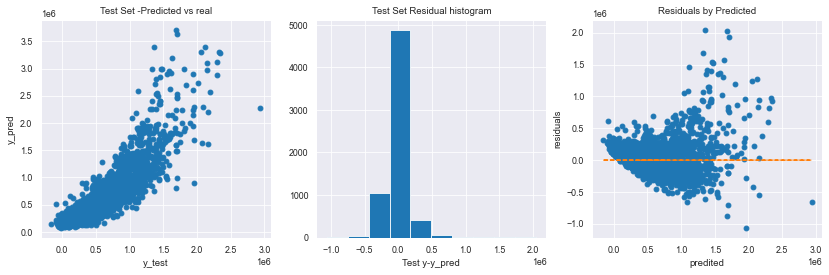

In [511]:
if show_prediction_plots:
    fig, ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].plot(y_pred, y_test, 'o')
    ax[0].set_xlabel("y_test")
    ax[0].set_ylabel("y_pred")
    ax[0].set_title("Test Set -Predicted vs real")

    # Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
    # It resembles a normal distribution?
    ax[1].hist(y_test - y_pred)
    ax[1].set_xlabel("Test y-y_pred")
    ax[1].set_title("Test Set Residual histogram")

    ax[2].plot(y_pred,y_test - y_pred,"o")
    ax[2].set_xlabel("predited")
    ax[2].set_ylabel("residuals")
    ax[2].set_title("Residuals by Predicted")
    ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

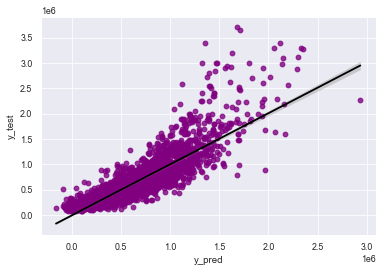

In [512]:
if show_prediction_plots:
    sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "purple"}, line_kws={"color": "black"})
if save_pred_plot:
        plt.savefig(f"./plots/residuals_plot_{filename_ext}.png")    

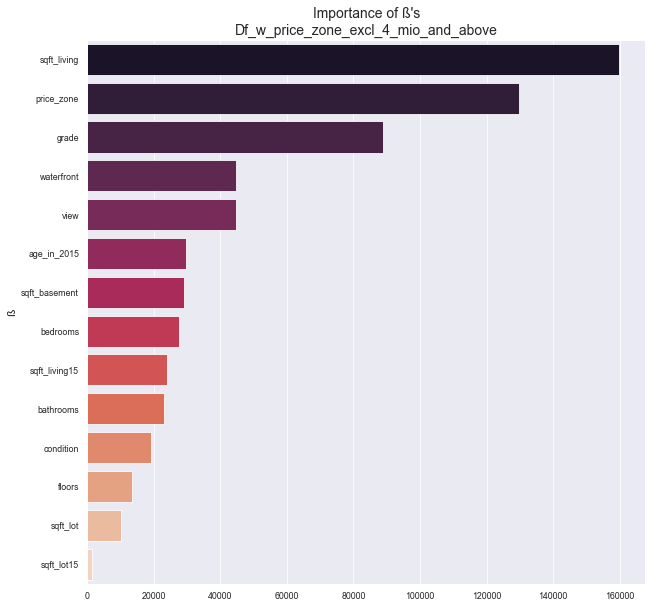

In [513]:
if show_beta_plot:
    sns.set_style("darkgrid")
    sns.set_context("paper")  # font scale lowered to avoid overlapping x-ticks
    fig, ax = plt.subplots(figsize=(10,10))
    sns.barplot(data=coef_df[:30], y=0, x=1, palette="rocket")
    ax.set_title(f"Importance of ß's\n{filename_ext.capitalize()}", size=14)
    ax.set_ylabel("ß", fontsize=12)
    ax.set_xlabel("")
    if save_beta_plot:
        plt.savefig(f"./plots/beta_importance_{filename_ext}.png")

##### 3.1.7.5 Error metrics Test

In [514]:
mse_test = mse(y_test,y_pred)
mae_test = mae(y_test,y_pred)

In [515]:
r2_test=r2_score(y_test,y_pred)


In [516]:
adj_r2_test= 1 - (1-r2_test)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)


##### 3.1.7.6 Error metrics Train

In [517]:
y_pred=model.predict(X_train_scaled)

In [518]:
mse_train = mse(y_train,y_pred)
mae_train = mae(y_train,y_pred)

In [519]:
r2_train=r2_score(y_train,y_pred)


In [520]:
adj_r2_train= 1 - (1-r2_train)*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)


***

<a id ="result"> </a>
### 3.2 Result Output

In [521]:
error_mat_txt = f""" 
Adjusted Dataset contains {round(len(this_model)/len(data)*100,2)} % of original data points ({len(this_model)} out of {len(data)}).

Error Metrics Test Set:
         MSE = {round(mse_test, 4)}
         MAE = {round(mae_test, 4)}
          R² = {round(r2_test, 4)}
 Adjusted R² = {round(adj_r2_test, 4)}

  - - - - - - - -

Error Metrics Train Set:
         MSE = {round(mse_train, 4)}
         MAE = {round(mae_train, 4)}
          R² = {round(r2_train, 4)}
 Adjusted R² = {round(adj_r2_train, 4)}"""


In [522]:
print(error_mat_txt)
if save_error_metric:
    with open(f"./error_metrics/{filename_ext}.txt", "w") as f:
        f.write(error_mat_txt)

 
Adjusted Dataset contains 99.94 % of original data points (21585 out of 21597).

Error Metrics Test Set:
         MSE = 31906935011.5845
         MAE = 115418.9963
          R² = 0.7482
 Adjusted R² = 0.7477

  - - - - - - - -

Error Metrics Train Set:
         MSE = 30810556536.1645
         MAE = 116171.4908
          R² = 0.7405
 Adjusted R² = 0.7403


In [523]:
print(filename_ext)

df_w_price_zone_excl_4_mio_and_above


<a id="hypothesis"></a>
## 4. Hypothesis Testing

### 4.1 The importance of the price zone

Three bedroom houses are most common in the dataset, do these houses in Zone 2 have a higher price on average than those in Zone 3? 

H0: average_price_3bed_zone2 = average_price_3bed_zone3<br>
Ha: average_price_3bed_zone2 ≠ average_price_3bed_zone3<br>

In [524]:
# population 1
df_3bed_zone2 = data[data["price_zone"].astype("int64") == 2]
df_3bed_zone2 = df_3bed_zone2[df_3bed_zone2["bedrooms"].astype("int64") == 3][["price"]]

In [525]:
# population 2
df_3bed_zone3 = data[data["price_zone"].astype("int64") == 3]
df_3bed_zone3 = df_3bed_zone3[df_3bed_zone3["bedrooms"].astype("int64") == 3][["price"]]


In [526]:
# samples
sample1 = df_3bed_zone2.sample(100, random_state=42)   # zone 2
sample2 = df_3bed_zone3.sample(100, random_state=42)   # zone 3



In [527]:
# sample mean
xbar1 = np.mean(sample1["price"]) 
xbar2 = np.mean(sample2["price"])


In [528]:
# S²
sample1["stdev"] = (xbar1 - sample1["price"])**2
sample2["stdev"] = (xbar2 - sample2["price"])**2


In [529]:
S1 = sum(sample1["stdev"]) / (len(sample1)-1)
S2 = sum(sample2["stdev"]) / (len(sample2)-1)

In [530]:
t = (xbar1 - xbar2) / ((S1/len(sample1)) + (S2/len(sample2)))**0.5
t

2.4340569238429732

In [531]:
import scipy.stats as stats
tc = stats.t.ppf(1-(0.05/2),df=100) 
tc

1.9839715184496334

In [532]:
if abs(t) <= tc:
    print("As the calculated t is equal to or smaller than the tc (in absolutes), we fail to reject the H0.")
else:
    print("As the calculated t is larger than the tc (in absolutes), the H0 is rejected.")


As the calculated t is larger than the tc (in absolutes), the H0 is rejected.


The price zone has an effect on the house prize.